In [1]:
import sys
import time
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader

from matplotlib.dates import DateFormatter
from matplotlib.colors import Normalize, LogNorm
from matplotlib import pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

# Over ride unnecessary loggers
logger = logging.getLogger("fbprophet")
handler2 = logging.StreamHandler(sys.stdout)
handler2.setLevel(logging.CRITICAL)
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)"
)
handler2.setFormatter(formatter)
logger.addHandler(handler2)
logger2 = logging.getLogger("pystan")
logger2.addHandler(handler2)

from fbprophet import Prophet
%matplotlib inline

sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (20,11)
countries = ["China", "India", "Australia", "Italy", "US"]

In [2]:
corona_detected = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [3]:
corona_df = pd.DataFrame()
# Set all dates as the index of the dataframe
corona_df["dates"] = (corona_detected.iloc[:, 4:].columns.to_list())
corona_df.set_index("dates", inplace=True)
# Convert date string to datetime object
corona_df.index = pd.to_datetime(corona_df.index, format = "%m/%d/%y")

In [4]:
# Add the countries to corona_df dataframe
for country in countries:
    corona_df[country] = corona_detected[corona_detected["Country/Region"] == country].iloc[:, 4:].sum()

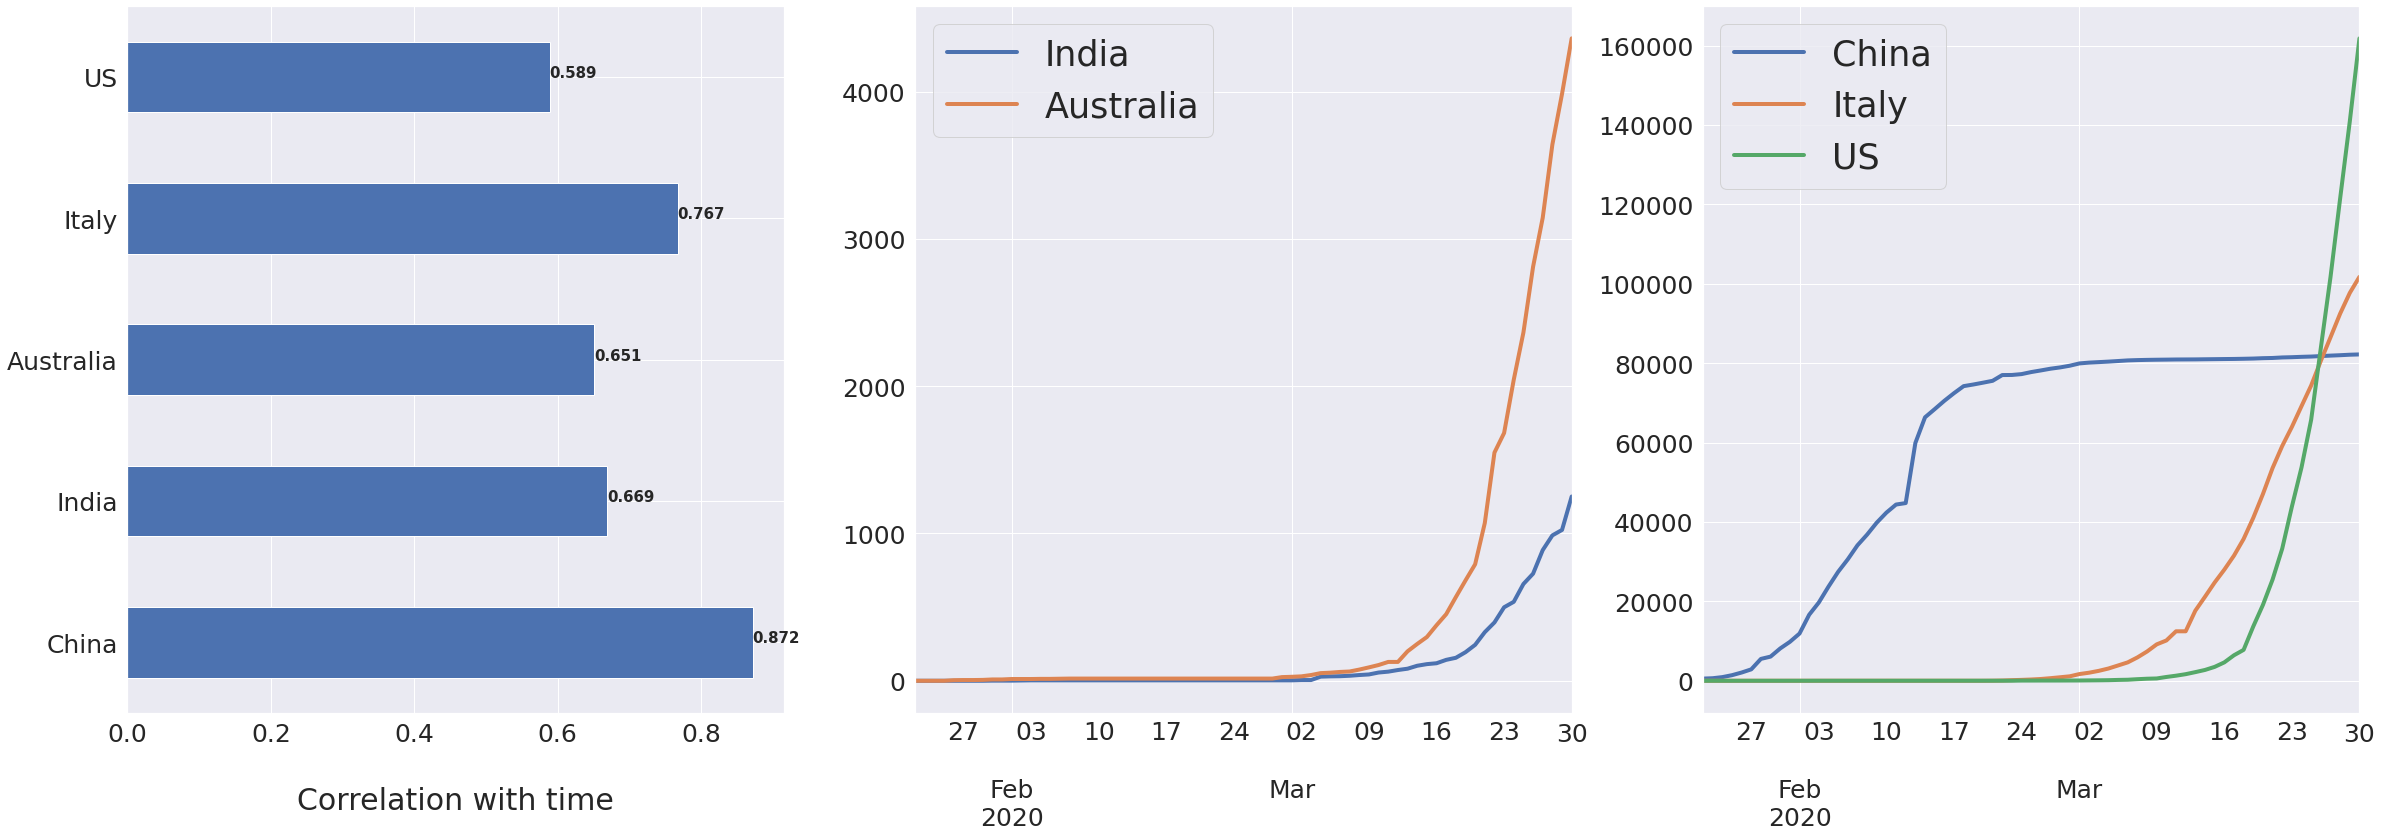

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(40, 13))
fig.subplots_adjust(wspace=0.2)
linewidth = 4

corr_with_time = corona_df.corrwith(pd.to_numeric(corona_df.index.to_series()))

corr_with_time.plot(kind="barh", ax=axs[0])
axs[0].tick_params(axis='both', labelsize=15)

axs[0].set_xlabel("Correlation with time", labelpad=40, 
                  fontdict={
                      'fontsize': 30
                  })

axs[0].tick_params(axis='both', labelsize=25, which="both")

for index, value in enumerate(corr_with_time):
    axs[0].text(value, index, str(round(value, 3)), fontweight='bold', fontsize = 15)

corona_df[["India", "Australia"]].plot(ax=axs[1], linewidth=linewidth)
corona_df[["China", "Italy", "US"]].plot(ax=axs[2], linewidth=linewidth)



for i in range(3):
    if i > 0:
        axs[i].tick_params(axis='both', labelsize=25, which="both")
        _ = axs[i].legend(fontsize="35")
        axs[i].xaxis.label.set_visible(False)

___

### China seems to follow an "S" curve or a sigmoid (logistic) function. 
### Fitting a logistic curve -



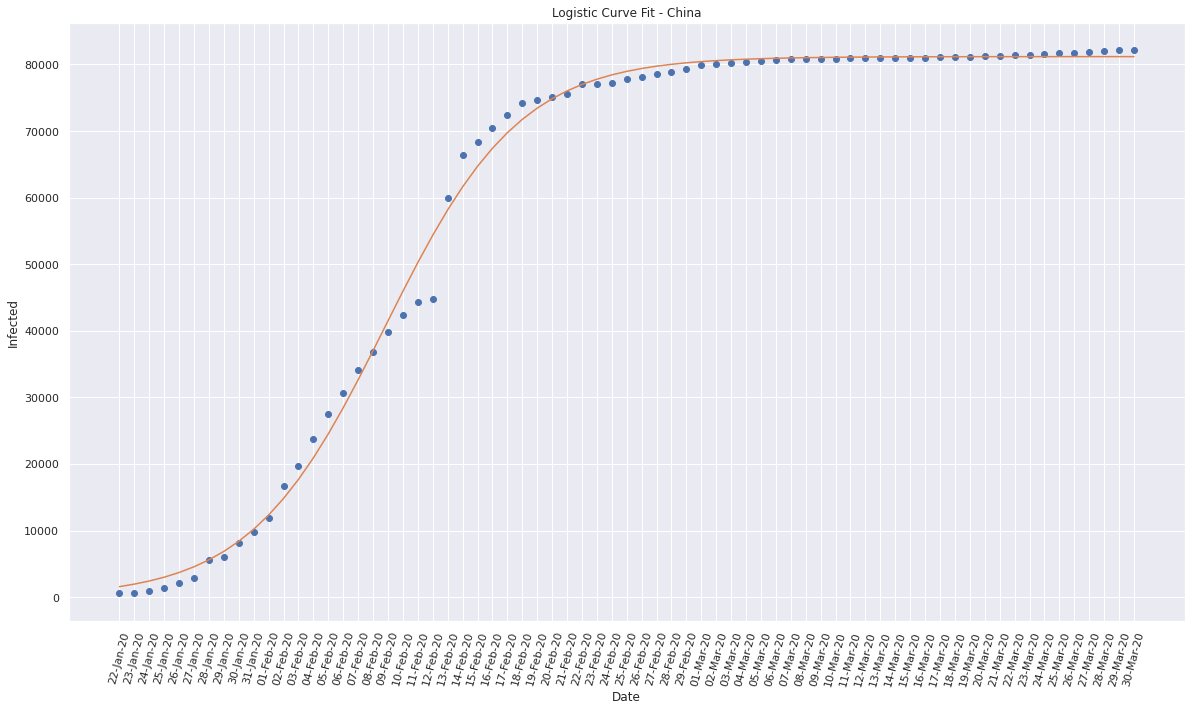

In [6]:
normalizing_factor = 1e10
epoch_conversion = 1e9

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

y_data = np.array(corona_df["China"].values)
x_data = np.array(corona_df.index.astype('int64')//epoch_conversion/normalizing_factor)


p0 = [max(y_data), np.median(x_data), 11, min(y_data)] 
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)

y = sigmoid(x_data, *popt)
_ = plt.plot(x_data, y_data, 'o', label='data')
_ = plt.plot(x_data,y, label='fit')
plt.xlabel('Date')
plt.ylabel('Infected')
plt.title("Logistic Curve Fit - China") 
labels = [time.strftime('%d-%b-%y', time.localtime(i*normalizing_factor)) for i in x_data]
_ = plt.xticks(x_data, labels, rotation=75)



___

### Fitting China's data for forecasting -

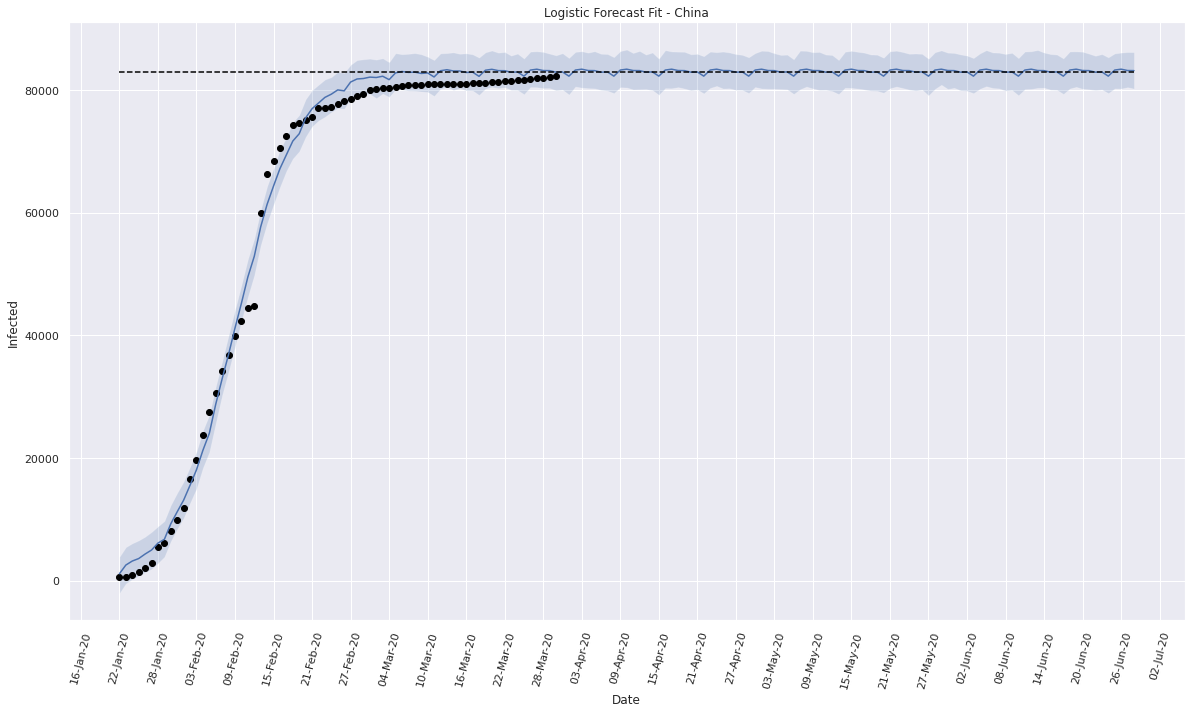

In [7]:
china_df = pd.DataFrame()
china_df["ds"] = corona_df.index
china_df["y"] = corona_df["China"].values

# Setting saturation to approximately 83,000 as coronavirus cases have saturated in China
china_df['cap'] = 83000

prophet = Prophet(growth='logistic')
prophet.fit(china_df)

future_df = prophet.make_future_dataframe(periods=90)
future_df['cap'] = 83000
frcst = prophet.predict(future_df)


data = {
    "dates": frcst["ds"], 
    "yhat_lower": frcst["yhat_lower"], 
    "yhat_upper": frcst["yhat_upper"], 
    "yhat": frcst["yhat"], 
    "cap": frcst["cap"],
}
forecast_df = pd.DataFrame(data=data)
fig, ax = plt.subplots()


fmt = DateFormatter("%d-%b-%y")
ax.xaxis.set_major_formatter(fmt)

dates = pd.to_datetime(forecast_df["dates"])

# Plot historical data
historical_numbers = corona_df["China"].values
ax.plot(dates[:len(historical_numbers)], historical_numbers, 'o', color="black")

# Plot predicted data
ax.plot(dates, forecast_df["yhat"])
ax.fill_between(dates, forecast_df["yhat_lower"], forecast_df["yhat_upper"], alpha=0.2)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='x', labelrotation=75)

ax.set_xlabel("Date")
ax.set_ylabel("Infected")
ax.set_title("Logistic Forecast Fit - China")

_ = ax.plot(dates, frcst["cap"], '--', color="black")

___
### Forecasting India's cases -

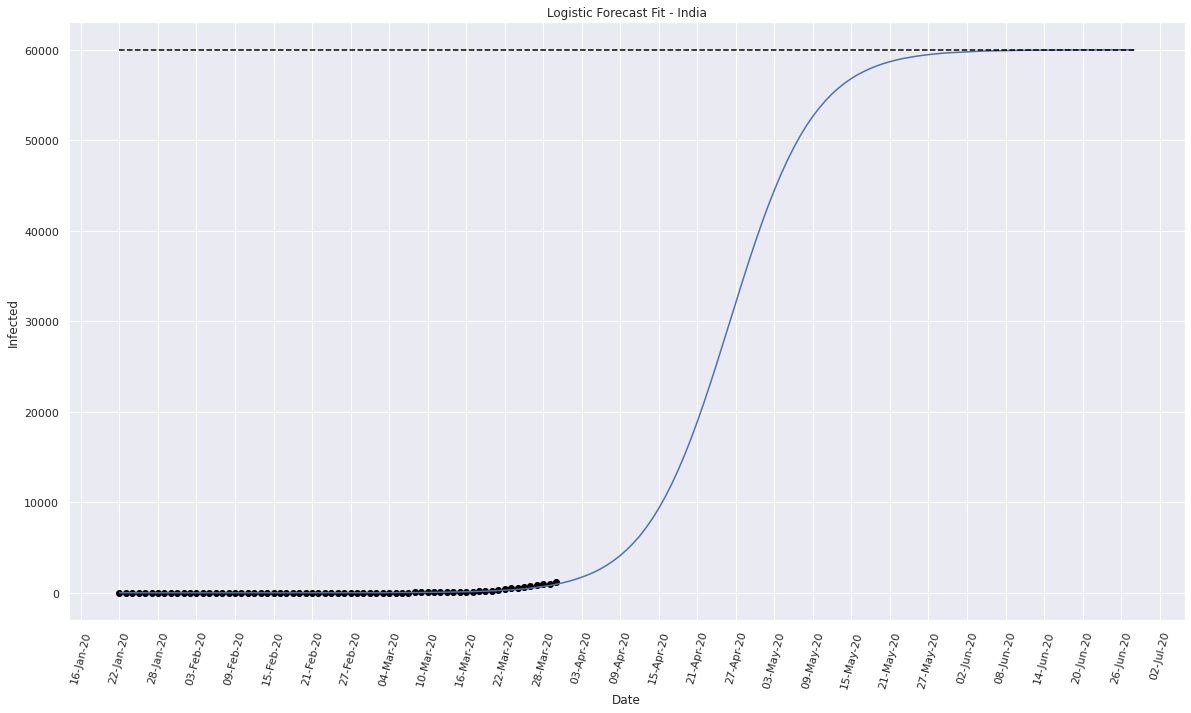

In [8]:
india_df = pd.DataFrame()
india_df["ds"] = corona_df.index
india_df["y"] = corona_df["India"].values

# Fitting India's capacity around the cases in China
_cap = []
i = 0
for infected in corona_df["India"]:
    if infected == 0:
        _cap.append(1)
    else:
        if infected > corona_df["China"][i]:
            _cap.append(infected+(infected-corona_df["China"][i]))
        else:
            _cap.append(corona_df["China"][i])
        i+=1

india_df['cap'] = _cap

prophet = Prophet(growth='logistic')
prophet.fit(india_df)

future_df = prophet.make_future_dataframe(periods=90)

# Carrying capacity fits correctly around 60,000 to 65,000

future_df['cap'] = 60000
frcst = prophet.predict(future_df)


data = {
    "dates": frcst["ds"], 
    "yhat_lower": frcst["yhat_lower"], 
    "yhat_upper": frcst["yhat_upper"], 
    "yhat": frcst["yhat"], 
    "cap": frcst["cap"],
}
forecast_df = pd.DataFrame(data=data)
fig, ax = plt.subplots()


fmt = DateFormatter("%d-%b-%y")
ax.xaxis.set_major_formatter(fmt)

dates = pd.to_datetime(forecast_df["dates"])

# Plot historical data
historical_numbers = corona_df["India"].values
ax.plot(dates[:len(historical_numbers)], historical_numbers, 'o', color="black")

# Plot predicted data
ax.plot(dates, forecast_df["yhat"])
ax.fill_between(dates, forecast_df["yhat_lower"], forecast_df["yhat_upper"], alpha=0.2)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='x', labelrotation=75)

ax.set_xlabel("Date")
ax.set_ylabel("Infected")
ax.set_title("Logistic Forecast Fit - India")

_ = ax.plot(dates, frcst["cap"], '--', color="black")

___

### Fitting Italy's data -

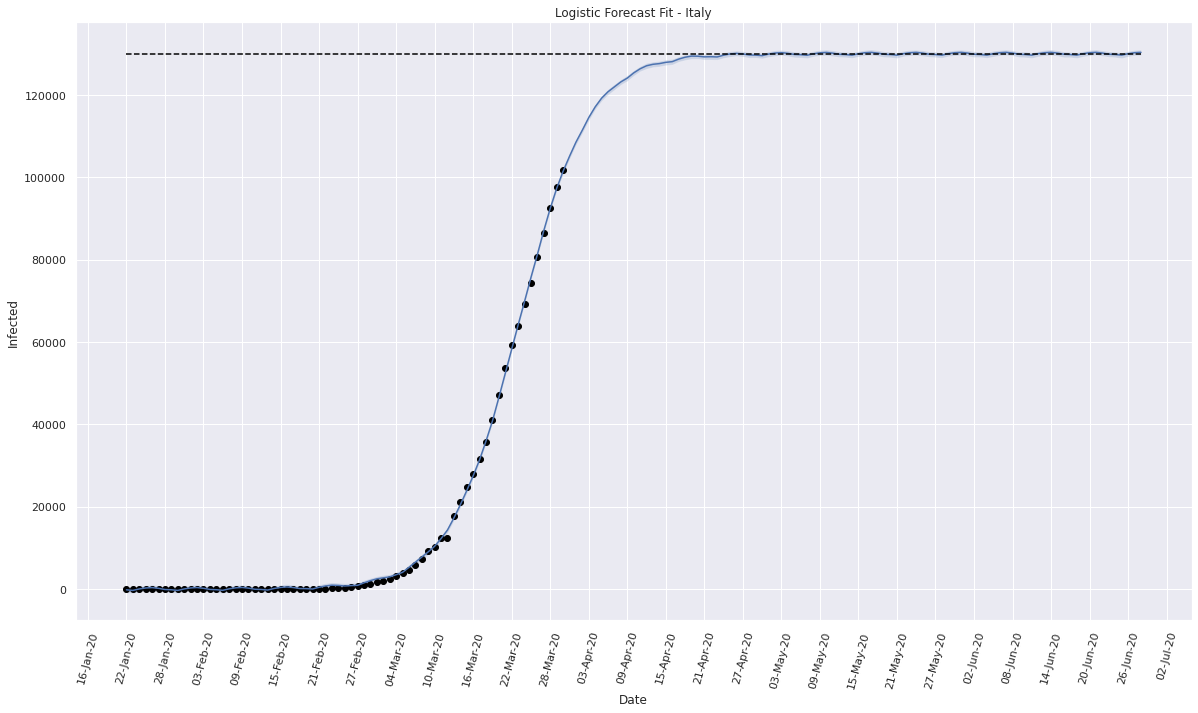

In [9]:
italy_df = pd.DataFrame()
italy_df["ds"] = corona_df.index
italy_df["y"] = corona_df["Italy"].values

# Setting saturation to approximately 130,000 as coronavirus cases have not yet saturated in Italy
italy_df['cap'] = 130000

prophet = Prophet(growth='logistic')
prophet.fit(italy_df)

future_df = prophet.make_future_dataframe(periods=90)
future_df['cap'] = 130000
frcst = prophet.predict(future_df)


data = {
    "dates": frcst["ds"], 
    "yhat_lower": frcst["yhat_lower"], 
    "yhat_upper": frcst["yhat_upper"], 
    "yhat": frcst["yhat"], 
    "cap": frcst["cap"],
}
forecast_df = pd.DataFrame(data=data)
fig, ax = plt.subplots()


fmt = DateFormatter("%d-%b-%y")
ax.xaxis.set_major_formatter(fmt)

dates = pd.to_datetime(forecast_df["dates"])

# Plot historical data
historical_numbers = corona_df["Italy"].values
ax.plot(dates[:len(historical_numbers)], historical_numbers, 'o', color="black")

# Plot predicted data
ax.plot(dates, forecast_df["yhat"])
ax.fill_between(dates, forecast_df["yhat_lower"], forecast_df["yhat_upper"], alpha=0.2)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='x', labelrotation=75)

ax.set_xlabel("Date")
ax.set_ylabel("Infected")
ax.set_title("Logistic Forecast Fit - Italy")

_ = ax.plot(dates, frcst["cap"], '--', color="black")

___
#### Population of Australia is closer to Italy than China. Therefore fitting Australia's carrying capaity around Italy's cases -

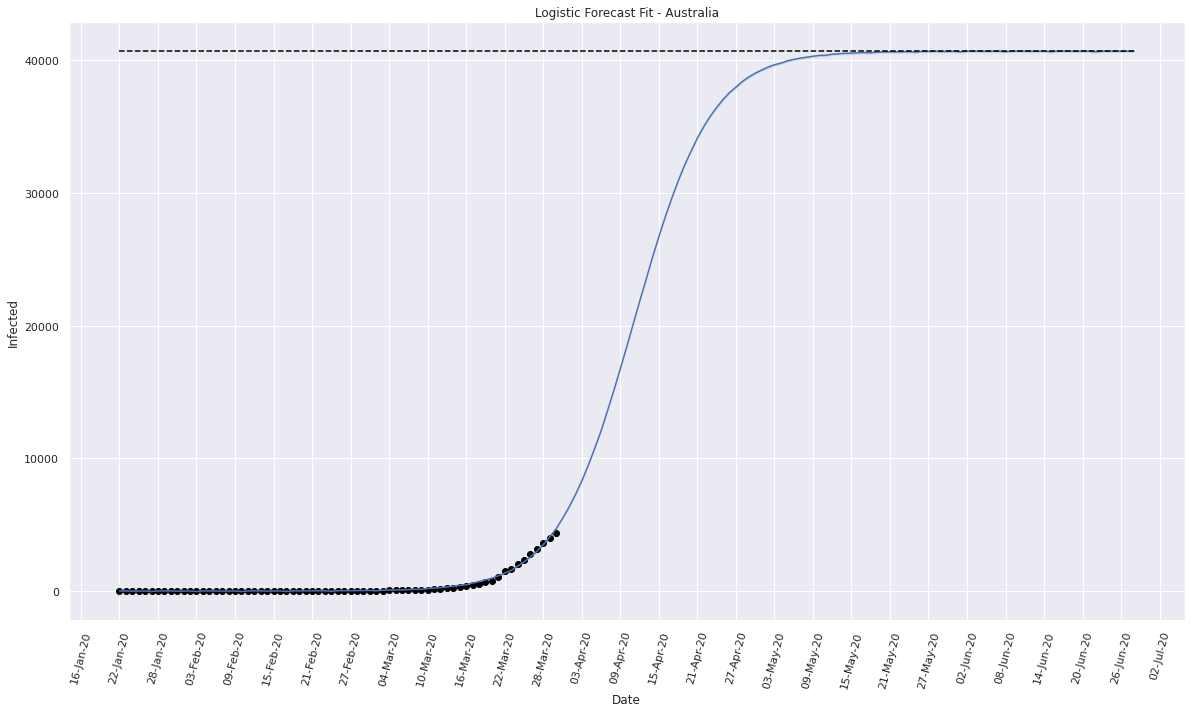

In [10]:
australia_df = pd.DataFrame()
australia_df["ds"] = corona_df.index
australia_df["y"] = corona_df["Australia"].values

# Italy's population is approximately 2.5 times more than Australia's. Diving the number of cases in Italy by 2.5
# and using that as carrying capacity for Australia

_cap = corona_df["Italy"][-1] / 2.5

australia_df["cap"] = _cap

prophet = Prophet(growth='logistic')
prophet.fit(australia_df)

future_df = prophet.make_future_dataframe(periods=90)

# Carrying capacity fits correctly around 60,000 to 65,000

future_df['cap'] = _cap
frcst = prophet.predict(future_df)


data = {
    "dates": frcst["ds"], 
    "yhat_lower": frcst["yhat_lower"], 
    "yhat_upper": frcst["yhat_upper"], 
    "yhat": frcst["yhat"], 
    "cap": frcst["cap"],
}
forecast_df = pd.DataFrame(data=data)
fig, ax = plt.subplots()


fmt = DateFormatter("%d-%b-%y")
ax.xaxis.set_major_formatter(fmt)

dates = pd.to_datetime(forecast_df["dates"])

# Plot historical data
historical_numbers = corona_df["Australia"].values
ax.plot(dates[:len(historical_numbers)], historical_numbers, 'o', color="black")

# Plot predicted data
ax.plot(dates, forecast_df["yhat"])
ax.fill_between(dates, forecast_df["yhat_lower"], forecast_df["yhat_upper"], alpha=0.2)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='x', labelrotation=75)

ax.set_xlabel("Date")
ax.set_ylabel("Infected")
ax.set_title("Logistic Forecast Fit - Australia")

_ = ax.plot(dates, frcst["cap"], '--', color="black")

In [11]:
"""
Countries you can fit -

'Argentina', 'Niger', 'Togo', 'Romania', 'Qatar', 'Tanzania', 'Saint Lucia', 'Burkina Faso', 'United Arab Emirates', 'Kenya', 'Italy', 
'Sweden', 'Holy See', 'Saint Vincent and the Grenadines', 'Singapore', 'Haiti', "Cote d'Ivoire", 'Maldives', 'Brazil', 'Dominican Republic',
'Kyrgyzstan', 'Iraq', 'Sri Lanka', 'Ghana', 'Moldova', 'Guatemala', 'Turkey', 'Andorra', 'Bosnia and Herzegovina', 'Chad', 'Japan', 
'Afghanistan', 'Panama', 'Netherlands', 'Oman', 'Angola', 'Bahamas', 'Bangladesh', 'Ukraine', 'Mozambique', 'Chile', 'China', 'Benin', 
'Belarus', 'Brunei', 'Pakistan', 'Switzerland', 'Kosovo', 'Congo (Kinshasa)', 'Slovakia', 'Somalia', 'Egypt', 'Tunisia', 'Greece', 
'Costa Rica', 'Serbia', 'Luxembourg', 'Spain', 'Saint Kitts and Nevis', 'Syria', 'Armenia', 'Rwanda', 'Equatorial Guinea', 'Thailand', 
'Jamaica', 'Jordan', 'Albania', 'South Africa', 'Liberia', 'Germany', 'Czechia', 'Philippines', 'Belize', 'Estonia', 'Austria', 'Guyana', 
'Mauritania', 'Venezuela', 'Uzbekistan', 'Namibia', 'Norway', 'Taiwan*', 'Mauritius', 'Zambia', 'Central African Republic', 'Russia', 
'Uganda', 'Timor-Leste', 'Kazakhstan', 'Korea, South', 'Portugal', 'Mongolia', 'Colombia', 'Israel', 'New Zealand', 'West Bank and Gaza', 
'Peru', 'Bulgaria', 'Cambodia', 'Kuwait', 'Congo (Brazzaville)', 'Slovenia', 'Laos', 'Libya', 'Barbados', 'Madagascar', 'Liechtenstein', 
'Poland', 'Lebanon', 'Cabo Verde', 'Iceland', 'Vietnam', 'France', 'Eswatini', 'North Macedonia', 'Bhutan', 'Cyprus', 'Grenada', 
'El Salvador', 'Algeria', 'Gambia', 'Mexico', 'Ecuador', 'Monaco', 'Belgium', 'Gabon', 'Eritrea', 'Suriname', 'Dominica', 'Nicaragua', 
'Georgia', 'Australia', 'Honduras', 'Zimbabwe', 'Cuba', 'Indonesia', 'Finland', 'Saudi Arabia', 'Trinidad and Tobago', 'Fiji', 'Latvia', 
'Bolivia', 'Malaysia', 'Seychelles', 'Lithuania', 'Iran', 'Nepal', 'US', 'Papua New Guinea', 'Paraguay', 'Bahrain', 'Denmark', 'Hungary', 
'Malta', 'Croatia', 'Canada', 'Guinea', 'Djibouti', 'Cameroon', 'United Kingdom', 'Ethiopia', 'Ireland', 'Azerbaijan', 
'Antigua and Barbuda', 'Morocco', 'Guinea-Bissau', 'Nigeria', 'Diamond Princess', 'San Marino', 'Mali', 'Senegal', 'India', 'Sudan', 
'Uruguay', 'Montenegro'

"""

def fit_country(country, carrying_capacity):
    if country in set(corona_detected["Country/Region"]):
        # Code to create a dataframe for the country
        corona_df = pd.DataFrame()
        # Set all dates as the index of the dataframe
        corona_df["dates"] = (corona_detected.iloc[:, 4:].columns.to_list())
        corona_df.set_index("dates", inplace=True)
        # Convert date string to datetime object
        corona_df.index = pd.to_datetime(corona_df.index, format = "%m/%d/%y")
        corona_df[country] = corona_detected[corona_detected["Country/Region"] == country].iloc[:, 4:].sum()
        
        country_df = pd.DataFrame()
        country_df["ds"] = corona_df.index
        country_df["y"] = corona_df["US"].values

        # Setting saturation to here
        country_df['cap'] = carrying_capacity

        prophet = Prophet(growth='logistic')
        prophet.fit(country_df)

        future_df = prophet.make_future_dataframe(periods=90)
        future_df['cap'] = carrying_capacity
        frcst = prophet.predict(future_df)


        data = {
            "dates": frcst["ds"], 
            "yhat_lower": frcst["yhat_lower"], 
            "yhat_upper": frcst["yhat_upper"], 
            "yhat": frcst["yhat"], 
            "cap": frcst["cap"],
        }
        forecast_df = pd.DataFrame(data=data)
        fig, ax = plt.subplots()


        fmt = DateFormatter("%d-%b-%y")
        ax.xaxis.set_major_formatter(fmt)

        dates = pd.to_datetime(forecast_df["dates"])

        # Plot historical data
        historical_numbers = corona_df["US"].values
        ax.plot(dates[:len(historical_numbers)], historical_numbers, 'o', color="black")

        # Plot predicted data
        ax.plot(dates, forecast_df["yhat"])
        ax.fill_between(dates, forecast_df["yhat_lower"], forecast_df["yhat_upper"], alpha=0.2)

        ax.xaxis.set_major_locator(plt.MaxNLocator(30))
        ax.tick_params(axis='x', labelrotation=75)
        
        ax.set_xlabel("Date")
        ax.set_ylabel("Infected")
        ax.set_title(f"Logistic Forecast Fit - {country}")

        _ = ax.plot(dates, frcst["cap"], '--', color="black")

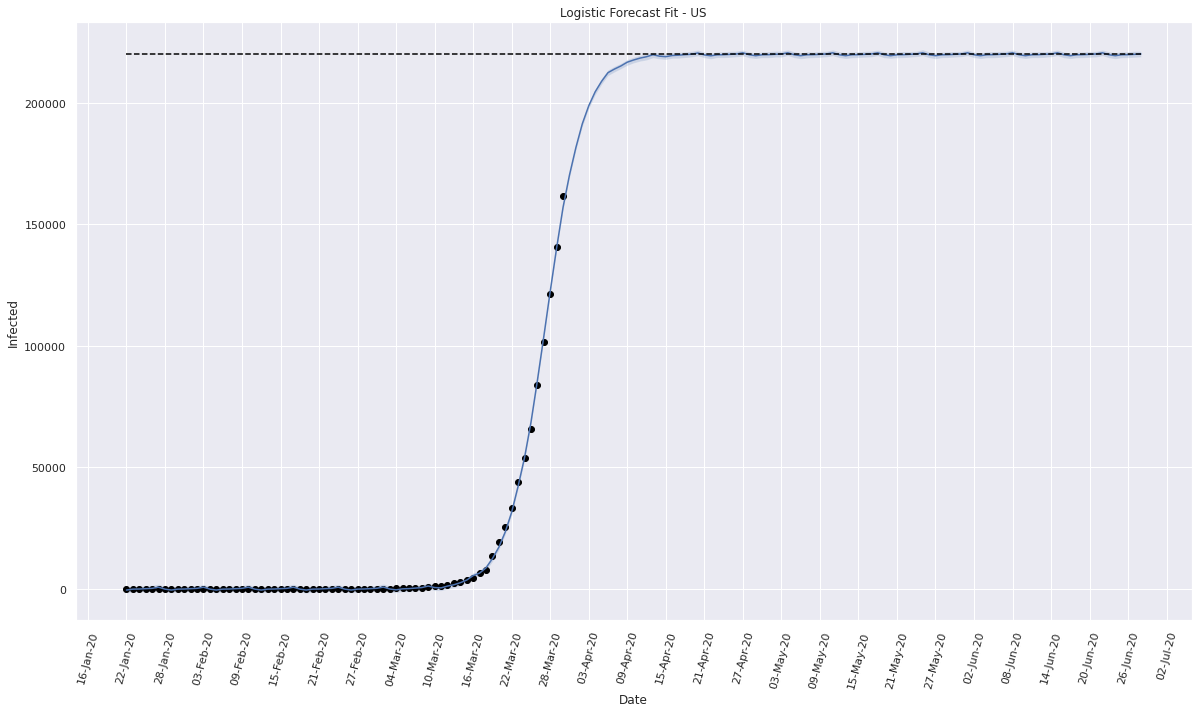

In [12]:
"""
Please run cell 1 and 2 before calling this function. Also run the cell above to initiate the function.

To fit a country, call the function like below. Arguments are -
country          : The country that you want to fit and get the forecast
carrying_capacity: The maximum value that you think it will reach

NOTE: If the predicted line is on the right of the scatter plot points, you can try increasing the
carrying capacity. Or you can decrease it to get the right fit.
"""
fit_country("US", 220000)

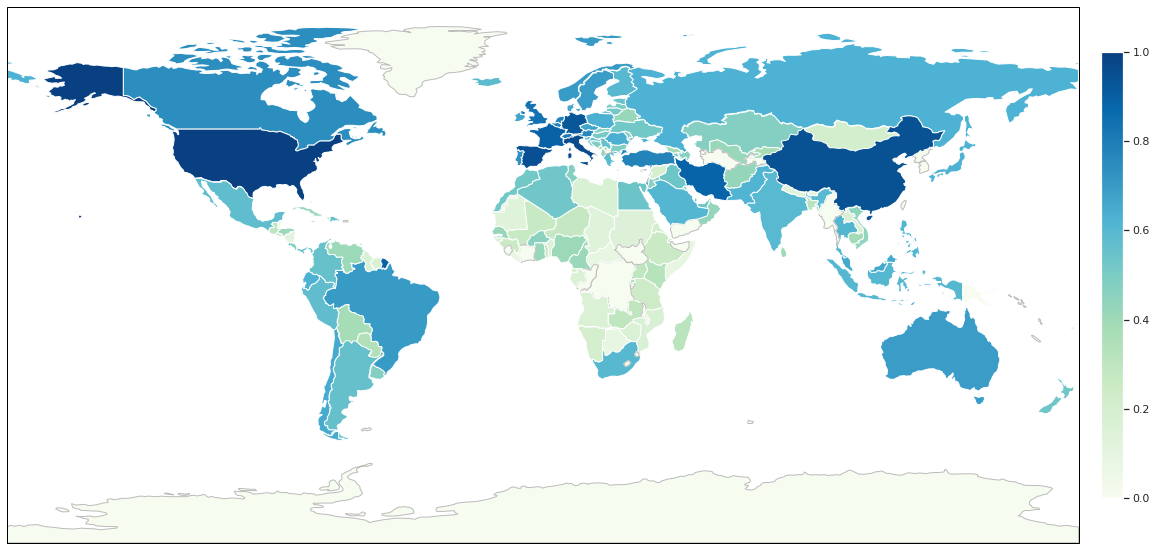

In [13]:
# This requires some more work as country names from the git page differ from 
# country names from shpreader

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

ax = plt.axes(projection=ccrs.PlateCarree())

summed_up = corona_detected.groupby(["Country/Region"]).sum()
summed_up = summed_up.iloc[:,-1].reset_index()
summed_up.rename(columns = {summed_up.columns[-1]: "Sum"}, inplace=True)

norm = LogNorm(vmin=min(summed_up["Sum"]), vmax=max(summed_up["Sum"]))
cmap = plt.cm.get_cmap("GnBu")

for country, count in zip(shpreader.Reader(countries_shp).records(), summed_up["Sum"].values):
    ctry = summed_up[(summed_up["Country/Region"] == country.attributes['NAME']) | (summed_up["Country/Region"] == country.attributes['NAME_LONG'])]
    if ctry["Sum"].values:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor=cmap(norm(ctry["Sum"].values[0])))
    elif country.attributes['NAME_LONG'] == "United States":
        ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor=cmap(norm(summed_up[summed_up["Country/Region"] == "US"]["Sum"].values[0])))
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor='#f7fcf0', edgecolor='#bcbcbc')

sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)
cbar.set_clim(min(summed_up["Sum"]), max(summed_up["Sum"]))

___
#### References -
* Thanks to Johns Hopkins University for providing the data. Github page - https://github.com/CSSEGISandData/COVID-19
* Thanks to the open source community for making the tools used available.